<a href="https://colab.research.google.com/github/ofer1992/dl-notes/blob/master/fastai_dl1/lesson1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airport interior classification

In [0]:
from fastai.vision import *

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Updating fastai...
Done.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


classification of airports by interior shots.
classes:
 - heathrow
 - jfk
 - suvarnabhumi
 - singapore
 - ben gurion

 
 step one is to build the dataset for google images

 ## Building the dataset

In [0]:
folders = ['heathrow', 'jfk', 'suvarnabhumi', 'singapore', 'ben_gurion']
files = [f'urls_{c}.csv' for c in folders]

In [0]:
#i = folders.index('heathrow')
#folder, file= folders[i], files[i]
path = Path(base_dir+'data/airports')
for folder, file in zip(folders, files):
  dest = path/folder
  #dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200)

In [0]:
classes = folders
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_size=500)

heathrow


jfk


suvarnabhumi


singapore


ben_gurion


## Viewing the data



In [0]:
path = Path(base_dir+'data/airports')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['ben_gurion', 'heathrow', 'jfk', 'singapore', 'suvarnabhumi']

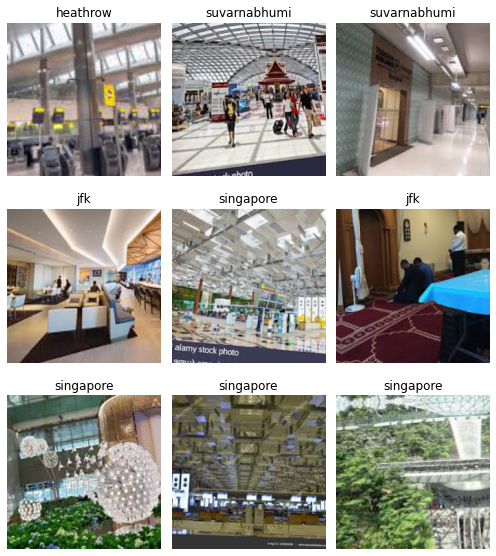

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['ben_gurion', 'heathrow', 'jfk', 'singapore', 'suvarnabhumi'], 5, 576, 144)

## Training a model

trained with resnet34, reached around 20% error rate. heathrow is the least predictable. anyway, trying with resnet50 now. similar results with resnet50.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.189574,2.614106,0.451389,00:20
1,1.706478,1.549083,0.381944,00:13


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


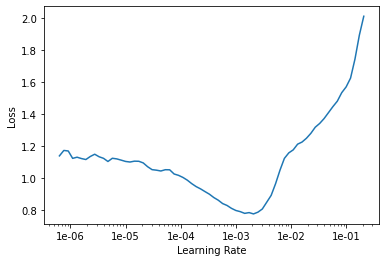

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.003532,1.343539,0.375000,00:17
1,0.782466,2.798568,0.458333,00:16
2,0.648132,1.721312,0.375000,00:17
3,0.535481,1.508240,0.298611,00:16
4,0.440177,1.350805,0.284722,00:17


In [0]:
learn.save('stage-2')

## Interperting

In [0]:
learn.load('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

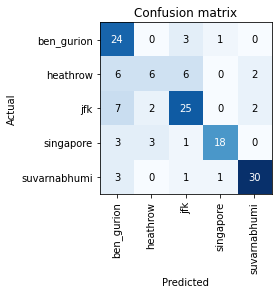

In [0]:
interp.plot_confusion_matrix()

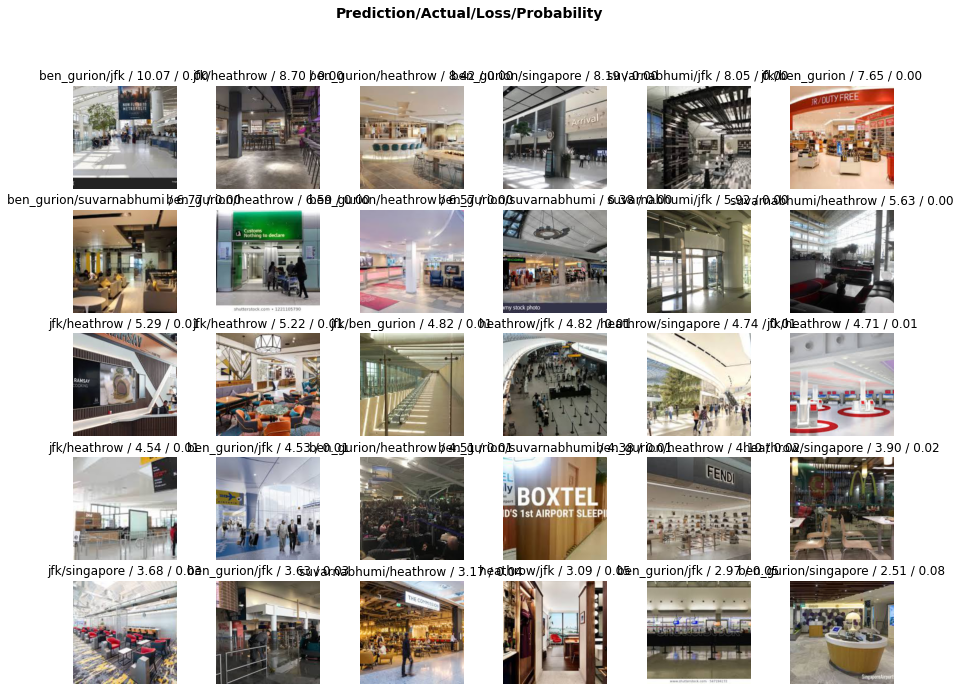

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

## Cleaning up the data

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

so there's a widget for cleaning up the dataset but it doesn't work in colab...

## prediction
let's try our model on some pictures

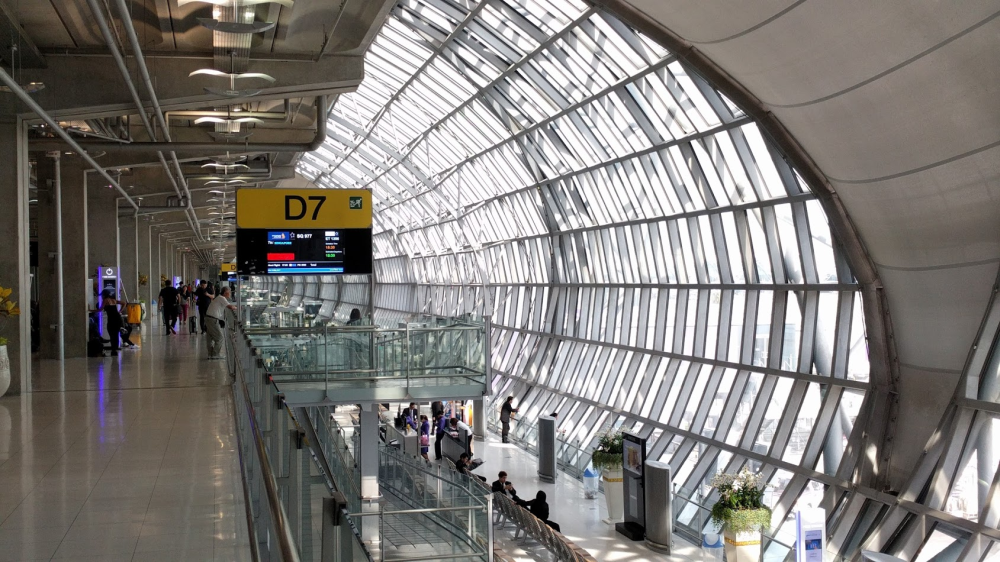

In [0]:
impath = Path(base_dir+"personal/")
impath.ls()
img = open_image(base_dir+"personal/su1.png")
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category suvarnabhumi